# Fit equivalent width on SED

- Author Sylvie Dagoret-Campagne
- Creation : April 9th 2022
- Update : October 7th 2019

In [1]:
import os
import numpy as np

In [2]:
from astropy.io import fits

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [4]:
from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, HGAMMA, HDELTA,HEPSILON
import astropy.units as u

In [5]:
import pysynphot as S

In [6]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')

In [7]:
plt.rcParams["axes.labelsize"]="large"
plt.rcParams["axes.linewidth"]=2.0
plt.rcParams["xtick.major.size"]=8
plt.rcParams["ytick.major.size"]=8
plt.rcParams["ytick.minor.size"]=5
plt.rcParams["xtick.labelsize"]="large"
plt.rcParams["ytick.labelsize"]="large"

plt.rcParams["figure.figsize"]=(24,18)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'bold'
#plt.rcParams['axes.facecolor'] = 'blue'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['lines.markeredgewidth'] = 0.3 # the line width around the marker symbol
plt.rcParams['lines.markersize'] = 5  # markersize, in points
plt.rcParams['grid.alpha'] = 0.75 # transparency, between 0.0 and 1.0
plt.rcParams['grid.linestyle'] = '-' # simple line
plt.rcParams['grid.linewidth'] = 0.4 # in points
plt.rcParams['font.size'] = 13

# Read calspec SED

In [8]:
sed_filename="eta1dor_stis_002.fits"
targetname="ETA1 DOR"

In [9]:
#sed_filename="mucol_stis_005.fits"
#targetname="Mu Col"

# Flux in linear scale

In [10]:
WLMIN=3000
WLMAX=11000

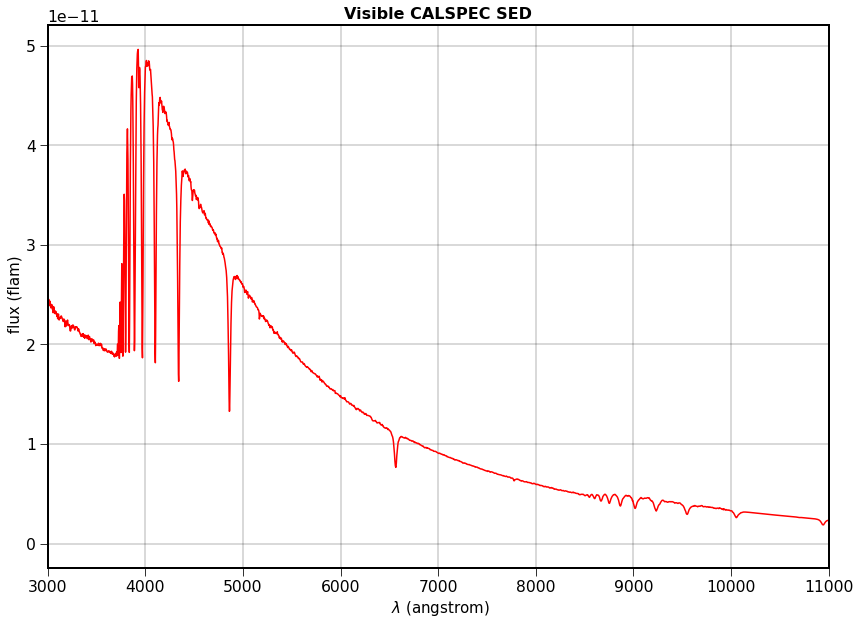

In [11]:

figure=plt.figure(figsize=(14,10))        
fullfilename=os.path.join(path_sed_calspec,sed_filename)
spec=S.FileSpectrum(fullfilename)
    
#        spec.convert('photlam')
#        spec.convert('nm')    
        
        
plt.plot(spec.wave, spec.flux,color="r")
            
plt.xlim(WLMIN,WLMAX)

plt.grid()

fign="all_viscalspec_spectra_lin.pdf"
xlabel=' $\\lambda$ ({})'.format(spec.waveunits.name)
ylabel=' flux ({})'.format(spec.fluxunits.name)
plt.xlabel(xlabel,fontsize=15)
plt.ylabel(ylabel,fontsize=15)
plt.title("Visible CALSPEC SED")
plt.grid(color="k")
plt.savefig(fign)

# Interpolate

In [12]:
WL=np.arange(WLMIN,WLMAX)

In [13]:
F=np.interp(WL,spec.wave, spec.flux)

# Compute equivalent width

In [14]:
from specutils import Spectrum1D
from specutils.fitting import fit_generic_continuum,fit_continuum
from specutils import SpectralRegion
from specutils.analysis import equivalent_width
from astropy.modeling import models
from specutils.manipulation import extract_region

In [15]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [16]:
lamb = WL * u.AA 
flux = F * u.Unit('erg cm-2 s-1 AA-1') 
#fluxerr = s.err * u.Unit('erg cm-2 s-1 AA-1')/10. 
spec = Spectrum1D(spectral_axis=lamb, flux=flux)
#specerr = Spectrum1D(spectral_axis=lamb, flux=fluxerr)

In [17]:
spec

<Spectrum1D(flux=<Quantity [2.41233470e-11, 2.39591855e-11, 2.37876432e-11, ...,
           2.33959744e-12, 2.34123242e-12, 2.34286739e-12] erg / (Angstrom cm2 s)>, spectral_axis=<SpectralAxis [ 3000.,  3001.,  3002., ..., 10997., 10998., 10999.] Angstrom>)>

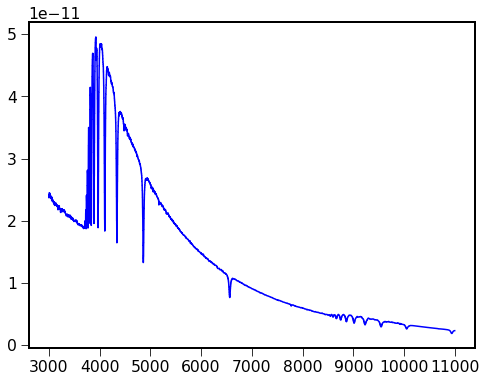

In [18]:
fig=plt.figure(figsize=(8,6)) 
ax = fig.add_subplot(1,1,1)  
ax.step(spec.spectral_axis, spec.flux,'b-') 

In [19]:
def ComputeMyEquivWidth(spec,wlmin,wlmax,wlminline,wlmaxline,flag_plot=True,ax1=None,ax2=None):
    """
    """
       # line central position        
    wlline0 = np.average([wlminline.value,wlmaxline.value])
    
    # region used to fit bacgroud        
    sub_region = SpectralRegion(wlmin , wlmax)
    # line region to remove background
    line_region = SpectralRegion(wlminline , wlmaxline)
    
    # region where one extract the spectrum
    sub_spectrum = extract_region(spec, sub_region)
    
    # initialisaition of linear model
    g_init = models.Linear1D(slope=0,intercept=1e-12)
    
    # fit on sub-spectrum
    g1_fit = fit_generic_continuum(sub_spectrum,model=g_init,exclude_regions=[line_region])
    # fit by keeping the whole spectrum , but fitting on hte relevant part of the spectrum
    g2_fit = fit_continuum(spec,model=g_init,window=sub_region,exclude_regions=[line_region])
    
    
    y_continuum_fitted1 = g1_fit(sub_spectrum.spectral_axis)
    y_continuum_fitted2 = g2_fit(spec.spectral_axis)
    
    # normalize the spectrum
    cont_norm_spec = spec/ y_continuum_fitted2 
    
    
    # work with inset
    idx_inset0 = np.where(np.logical_and(spec.spectral_axis>wlminline , spec.spectral_axis<wlmaxline))[0]
    idx_inset1 = np.where(np.logical_and(spec.spectral_axis>wlmin , spec.spectral_axis<wlmax))[0]
    
    
    wl_inset0 = spec.spectral_axis[idx_inset0]
    wl_inset1 = spec.spectral_axis[idx_inset1]
    
    fluxratio_inset0 = 1-cont_norm_spec.flux[idx_inset0]
    fluxratio_inset1 = 1-cont_norm_spec.flux[idx_inset1]
    
    # compute equivalent width by integration of (1-fluxratio(wl)) dwl
    eqw3 = np.trapz(fluxratio_inset0,wl_inset0)
    
    
    eqw1=equivalent_width(cont_norm_spec, regions=line_region) 
    eqw2=equivalent_width(cont_norm_spec, regions=sub_region)  
    
    
    if flag_plot:
        
        YMIN=spec.flux.min()
        YMAX=1.2*spec.flux.max()
        
        eqw_str1="$Eqw_1$ = {:2.2f} $\AA$ ".format(eqw1.value)
        eqw_str2="$Eqw_2$ = {:2.2f} $\AA$ ".format(eqw2.value)
        eqw_str3="$Eqw_3$ = {:2.2f} $\AA$ ".format(eqw3.value)
    
    
        eqw_str='\n'.join((
        r'{}'.format(eqw_str1),
        r'{}'.format(eqw_str2),
        r'{}'.format(eqw_str3)))
        
        if ax1==None: 
            f, ax1 = plt.subplots(figsize=(8,4))
            
        ax1.plot(spec.spectral_axis, spec.flux,'k-')  
        ax1.plot(sub_spectrum.spectral_axis, y_continuum_fitted1,'r-.',label="fit region")  
        ax1.plot(spec.spectral_axis, y_continuum_fitted2,'b:',label="extrapolated fit continuum")  
        ax1.set_title("Local continuum fitting")  
        ax1.grid(True)  
        ax1.legend()
        ax1.axvline(wlminline.value,color='r')
        ax1.axvline(wlmaxline.value,color="r")
        ax1.axvline(wlmin.value,color='g')
        ax1.axvline(wlmax.value,color="g")
        ax1.set_ylim(YMIN.value,YMAX.value)
        
        
        if ax2==None:
            f, ax2 = plt.subplots(figsize=(8,4)) 
            
            
        ax2.plot(spec.spectral_axis, cont_norm_spec.flux,'k-')  
        ax2.set_title("Equivalent width")  
        ax2.grid(True)  
        ax2.legend()
        ax2.axvline(wlminline.value,color='r')
        ax2.axvline(wlmaxline.value,color="r")
        ax2.axvline(wlmin.value,color='g')
        ax2.axvline(wlmax.value,color="g")
        ax2.set_ylim(0,2)
        if wlline0 > 7000:
            ax2.text(0.05, 0.3, eqw_str, transform=ax2.transAxes, fontsize=12,verticalalignment='top', bbox=props)
        else:
            ax2.text(0.55, 0.3, eqw_str, transform=ax2.transAxes, fontsize=12,verticalalignment='top', bbox=props)
                    
        
        # plot insert  on right figure
        if wlline0 > 7000:
            loc=2
        else:
            loc=1
        
        axins = inset_axes(ax2,
                    width="42%", # width = 30% of parent_bbox
                    height="42%", # height : 1 inch
                    loc=loc)
        axins.plot(spec.spectral_axis[idx_inset1], cont_norm_spec.flux[idx_inset1],'b-')
        axins.plot(spec.spectral_axis[idx_inset0], cont_norm_spec.flux[idx_inset0],'r-o')
        
        #axins.plot(wl_inset1, fluxratio_inset1,'b-')
        #axins.plot(wl_inset0, fluxratio_inset0,'r-o')
            
        
        axins.grid()
        
        
        
        # plot insert  on right figure
        if wlline0 > 7000:
            loc=3
        else:
            loc=4
        
        axins1 = inset_axes(ax1,
                    width="30%", # width = 30% of parent_bbox
                    height="30%", # height : 1 inch
                    loc=loc)
        axins1.plot(spec.spectral_axis[idx_inset1], cont_norm_spec.flux[idx_inset1],'b-')
        axins1.plot(spec.spectral_axis[idx_inset0], cont_norm_spec.flux[idx_inset0],'r-o')
        
        #axins.plot(wl_inset1, fluxratio_inset1,'b-')
        #axins.plot(wl_inset0, fluxratio_inset0,'r-o')
            
        
        axins1.grid()
            
        
    return eqw1.value,eqw2.value,eqw3.value     


## Halpha

In [20]:
wlmin=10*(HALPHA.wavelength-30)*u.AA
wlmax=10*(HALPHA.wavelength+30)*u.AA
wlminline=10*(HALPHA.wavelength-10)*u.AA
wlmaxline=10*(HALPHA.wavelength+10)*u.AA

2022-04-10 00:17:01  astropy    _showwarning         WARNING Model is linear in parameters; consider using linear fitting methods.


Text(0.5, 0.98, 'equivalent width of Halpha line for target ETA1 DOR')

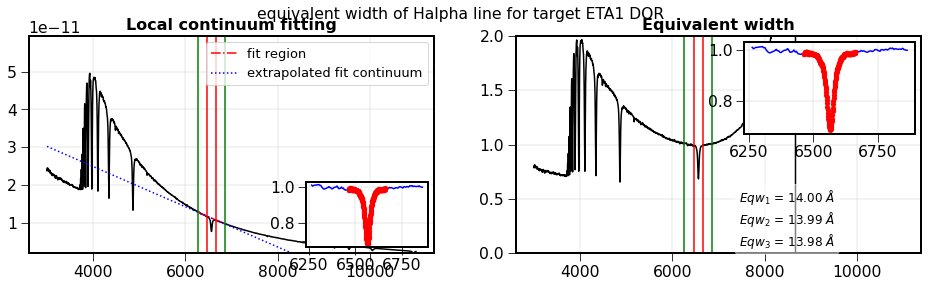

In [21]:
fig=plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
#eq1,eq2=ComputeEquivWidth(spec,wlmin,wlmax,wlminline,wlmaxline,flag_plot=True,ax1=ax1,ax2=ax2)
eq1,eq2,eq3=ComputeMyEquivWidth(spec,wlmin,wlmax,wlminline,wlmaxline,flag_plot=True,ax1=ax1,ax2=ax2)
plt.suptitle(f"equivalent width of Halpha line for target {targetname}")

## Hbeta

In [22]:
wlmin=10*(HBETA.wavelength-35)*u.AA
wlmax=10*(HBETA.wavelength+30)*u.AA
wlminline=10*(HBETA.wavelength-7)*u.AA
wlmaxline=10*(HBETA.wavelength+7)*u.AA

2022-04-10 00:17:07  astropy    _showwarning         WARNING Model is linear in parameters; consider using linear fitting methods.


Text(0.5, 0.98, 'equivalent width of Halpha line for target ETA1 DOR')

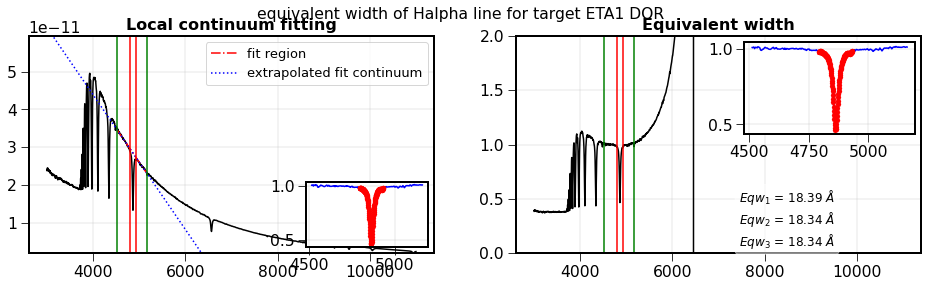

In [23]:
fig=plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
#eq1,eq2=ComputeEquivWidth(spec,wlmin,wlmax,wlminline,wlmaxline,flag_plot=True,ax1=ax1,ax2=ax2)
eq1,eq2,eq3=ComputeMyEquivWidth(spec,wlmin,wlmax,wlminline,wlmaxline,flag_plot=True,ax1=ax1,ax2=ax2)
plt.suptitle(f"equivalent width of Halpha line for target {targetname}")

## HGamma

In [24]:
wlmin=10*(HGAMMA.wavelength-10)*u.AA
wlmax=10*(HGAMMA.wavelength+10)*u.AA
wlminline=10*(HGAMMA.wavelength-6)*u.AA
wlmaxline=10*(HGAMMA.wavelength+7)*u.AA

2022-04-10 00:17:13  astropy    _showwarning         WARNING Model is linear in parameters; consider using linear fitting methods.


Text(0.5, 0.98, 'equivalent width of Hgamma line for target ETA1 DOR')

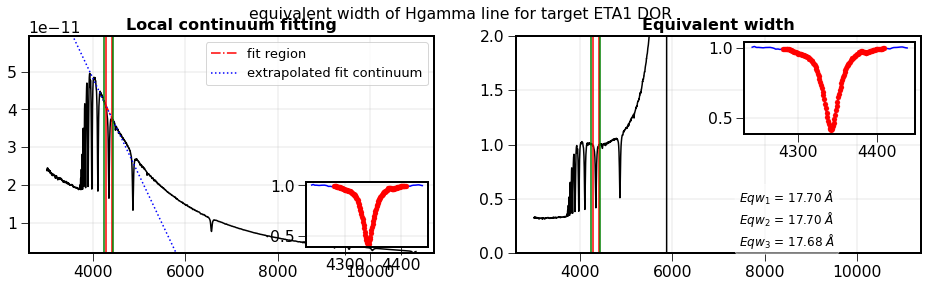

In [25]:
fig=plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
#eq1,eq2=ComputeEquivWidth(spec,wlmin,wlmax,wlminline,wlmaxline,flag_plot=True,ax1=ax1,ax2=ax2)
eq1,eq2,eq3=ComputeMyEquivWidth(spec,wlmin,wlmax,wlminline,wlmaxline,flag_plot=True,ax1=ax1,ax2=ax2)
plt.suptitle(f"equivalent width of Hgamma line for target {targetname}")